In [2]:
# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Create engine using the `hawaii.sqlite` database file
filepath = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{filepath}")

In [31]:
#examine station table
query = "SELECT * FROM station LIMIT 5"

df = pd.read_sql(text(query), con=engine)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [32]:
#examine measurement table
query2 = "SELECT * FROM measurement LIMIT 5"

dft = pd.read_sql(text(query2), con=engine)
dft.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [33]:
# INSPECT TABLES

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [34]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [35]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# the station class to a variable called `Station`
Station = Base.classes.station

In [36]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# retrieve the data and precipitation scores
# query
results = session.query(Measurement.date, Measurement.prcp, Measurement.station,).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).\
    all()

# # Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Date", "Precipitation", "Station ID"])

df2.head()

,Date,Precipitation,Station ID
0,2016-08-23,0.00,USC00519397
1,2016-08-23,0.15,USC00513117
2,2016-08-23,0.05,USC00514830
3,2016-08-23,NaN,USC00517948
4,2016-08-23,0.02,USC00519523


In [39]:
# # Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2_sort = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)
df2_sort

,Date,Precipitation,Station ID
0,2016-08-23,0.00,USC00519397
1,2016-08-23,0.15,USC00513117
2,2016-08-23,0.05,USC00514830
3,2016-08-23,NaN,USC00517948
4,2016-08-23,0.02,USC00519523
...,...,...,...
2225,2017-08-22,0.50,USC00516128
2226,2017-08-23,0.08,USC00519523
2227,2017-08-23,0.00,USC00519397
2228,2017-08-23,0.00,USC00514830


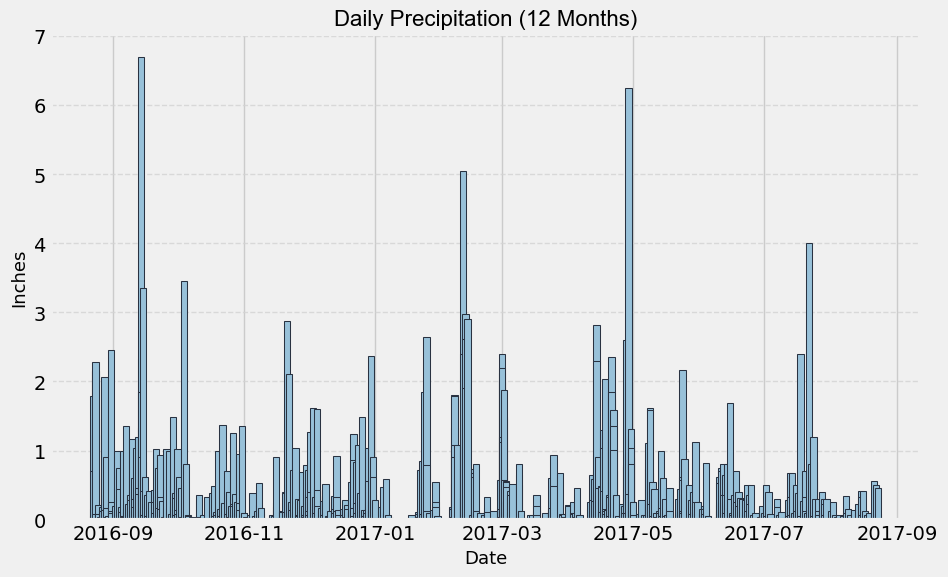

In [40]:
x=df2_sort.Date
y=df2_sort.Precipitation

# # Use Pandas Plotting with Matplotlib to plot the data
#canvas
plt.figure(figsize=(10,6))

#data
p1=plt.bar(x, y, color="#98c1d9", edgecolor="#293241", linewidth=.75, width=3)
#customize

plt.ylabel("Inches", fontsize=13)
plt.xlabel("Date", fontsize=13)
plt.title("Daily Precipitation (12 Months)", fontfamily="Arial", fontsize=16)
plt.grid(axis="y", color="lightgrey", linestyle="--", alpha=0.8)

plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2_sort.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number of stations in the dataset
# QUERY using the ORM

results = session.query(Measurement).join(Station, Measurement.station == Station.station).group_by(Measurement.station).count()
results

9

In [76]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]

stations = session.query(*sel).join(Station, Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_list = pd.DataFrame(stations, columns=["Station ID", "Rows"])
station_list


,Station ID,Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [71]:
#return most active station
results = session.query(Measurement.station).join(Station, Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

most_active_id = results[0]
most_active_id


'USC00519281'

In [83]:
#return most active station
most_active = session.query(Measurement.station).join(Station, Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

station_id = most_active[0]

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

stats = session.query(*sel).filter(Measurement.station == station_id).all()

df3 = pd.DataFrame(stats, columns=["ID", "Min", "Max", "Average"])
df3

,ID,Min,Max,Average
0,USC00519281,54.0,85.0,71.663781


In [85]:
# Using the most active station id
most_active_id = station_id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Starting from the most recent data point in the database.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == most_active_id).all()

# # Save the query results as a Pandas DataFrame. Explicitly set the column names
df5 = pd.DataFrame(results, columns=["Date", "TOBS"])

# # Sort the dataframe by date
df5["Date"] = pd.to_datetime(df5['Date'])
df5_sort = df5.sort_values(by="Date", ascending=True).reset_index(drop=True)
df5_sort

,Date,TOBS
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


/Users/redhawkwax/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/redhawkwax/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/redhawkwax/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


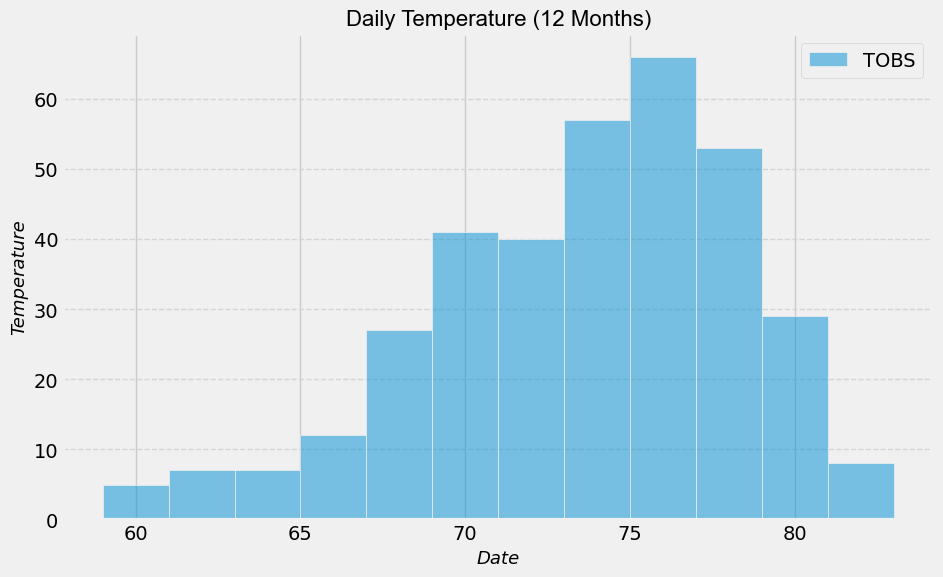

In [90]:
# plot the data
x=df5_sort.Date
y=df5_sort.TOBS

#canvas
plt.figure(figsize=(10,6))

#data
sns.histplot(data=df5, color="#274c77", bins=12)

#customize
plt.ylabel("Temperature", fontsize=13, fontstyle="italic")
plt.xlabel("Date", fontsize=13, fontstyle="italic")
plt.title("Daily Temperature (12 Months)", fontfamily="Arial", fontsize=16)
plt.grid(axis="y", color="lightgray", linestyle="--", alpha=0.9)

plt.show()

# Close Session

In [62]:
# Close Session
session.close()
